In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import  RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline


In [203]:
df = pd.read_csv('data/loan_approval_dataset.csv')
df.head()

loan_id  no_of_dependents     education self_employed  income_annum  \
0        1                 2      Graduate            No       9600000   
1        2                 0  Not Graduate           Yes       4100000   
2        3                 3      Graduate            No       9100000   
3        4                 3      Graduate            No       8200000   
4        5                 5  Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value loan_status  
0                 17600000             22700000           8000000    Approved  
1                  2200000              8800000           3300000    Rejected  
2                  4500000             33300000          12800000    Rejected  
3                  3300000             23300000           7900000    Rejected  
4                  8200000             29400000           5000000    Rejected

In [204]:
num_cols = ['income_annum', 'loan_amount', 'residential_assets_value', 'commercial_assets_value',
            'luxury_assets_value', 'bank_asset_value', 'cibil_score', 'no_of_dependents', 'loan_term']

cat_cols = ['education', 'self_employed']

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [206]:
df.columns

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

In [207]:
df.describe().T


count          mean           std       min  \
loan_id                   4269.0  2.135000e+03  1.232498e+03       1.0   
no_of_dependents          4269.0  2.498712e+00  1.695910e+00       0.0   
income_annum              4269.0  5.059124e+06  2.806840e+06  200000.0   
loan_amount               4269.0  1.513345e+07  9.043363e+06  300000.0   
loan_term                 4269.0  1.090045e+01  5.709187e+00       2.0   
cibil_score               4269.0  5.999361e+02  1.724304e+02     300.0   
residential_assets_value  4269.0  7.472617e+06  6.503637e+06 -100000.0   
commercial_assets_value   4269.0  4.973155e+06  4.388966e+06       0.0   
luxury_assets_value       4269.0  1.512631e+07  9.103754e+06  300000.0   
bank_asset_value          4269.0  4.976692e+06  3.250185e+06       0.0   

                                25%         50%         75%         max  
loan_id                      1068.0      2135.0      3202.0      4269.0  
no_of_dependents                1.0         3.0         4.0         5.0  
income_annum              2700000.0   5100000.0   7500000.0   9900000.0  
loan_amount               7700000.0  14500000.0  21500000.0  39500000.0  
loan_term                       6.0        10.0        16.0        20.0  
cibil_score                   453.0       600.0       748.0       900.0  
residential_assets_value  2200000.0   5600000.0  11300000.0  29100000.0  
commercial_assets_value   1300000.0   3700000.0   7600000.0  19400000.0  
luxury_assets_value       7500000.0  14600000.0  21700000.0  39200000.0  
bank_asset_value          2300000.0   4600000.0   7100000.0  14700000.0

In [208]:
for col in df.select_dtypes(include='object').columns:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())



Column: education
education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

Column: self_employed
self_employed
Yes    2150
No     2119
Name: count, dtype: int64

Column: loan_status
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


In [209]:
# count missing values
nulls_values = df.isnull().sum()
print("\nMissing values in each column:\n", nulls_values)




Missing values in each column:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


In [210]:
na_values = df.isna().sum()
print("\nNA values in each column:\n", na_values)


NA values in each column:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


In [211]:
nan_values = df.isna().sum()
print("\nNaN values in each column:\n", nan_values)


NaN values in each column:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


In [212]:
df.drop(columns='loan_id', inplace=True)

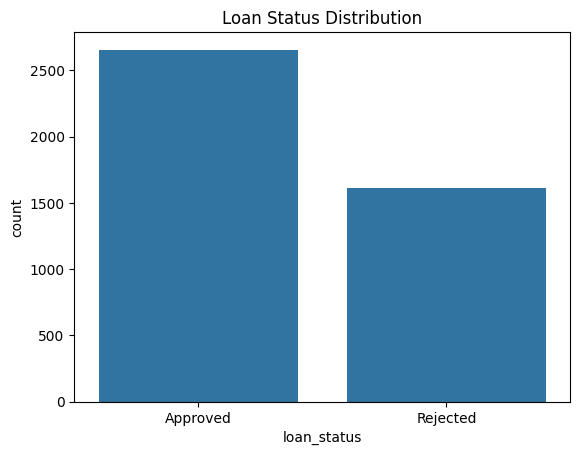

In [213]:
# Visualizations

sns.countplot(x='loan_status', data=df)
plt.title('Loan Status Distribution')
plt.show()


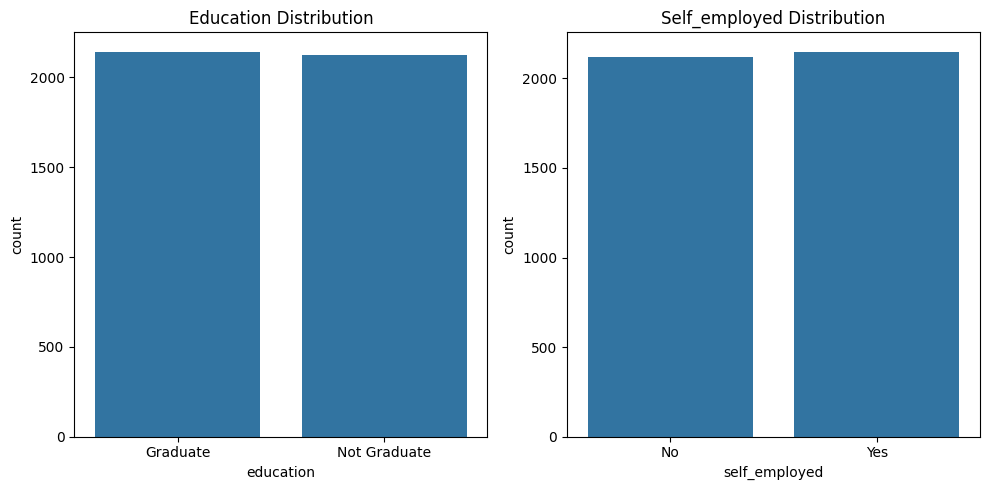

In [214]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  # 2 rows x 4 columns
axes = axes.flatten()  # make it a 1D array for easy indexing


categorical_cols = ['education', 'self_employed']
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df,  ax=axes[i])
    axes[i].set_title(f'{col.capitalize()} Distribution')

plt.tight_layout()
plt.show()


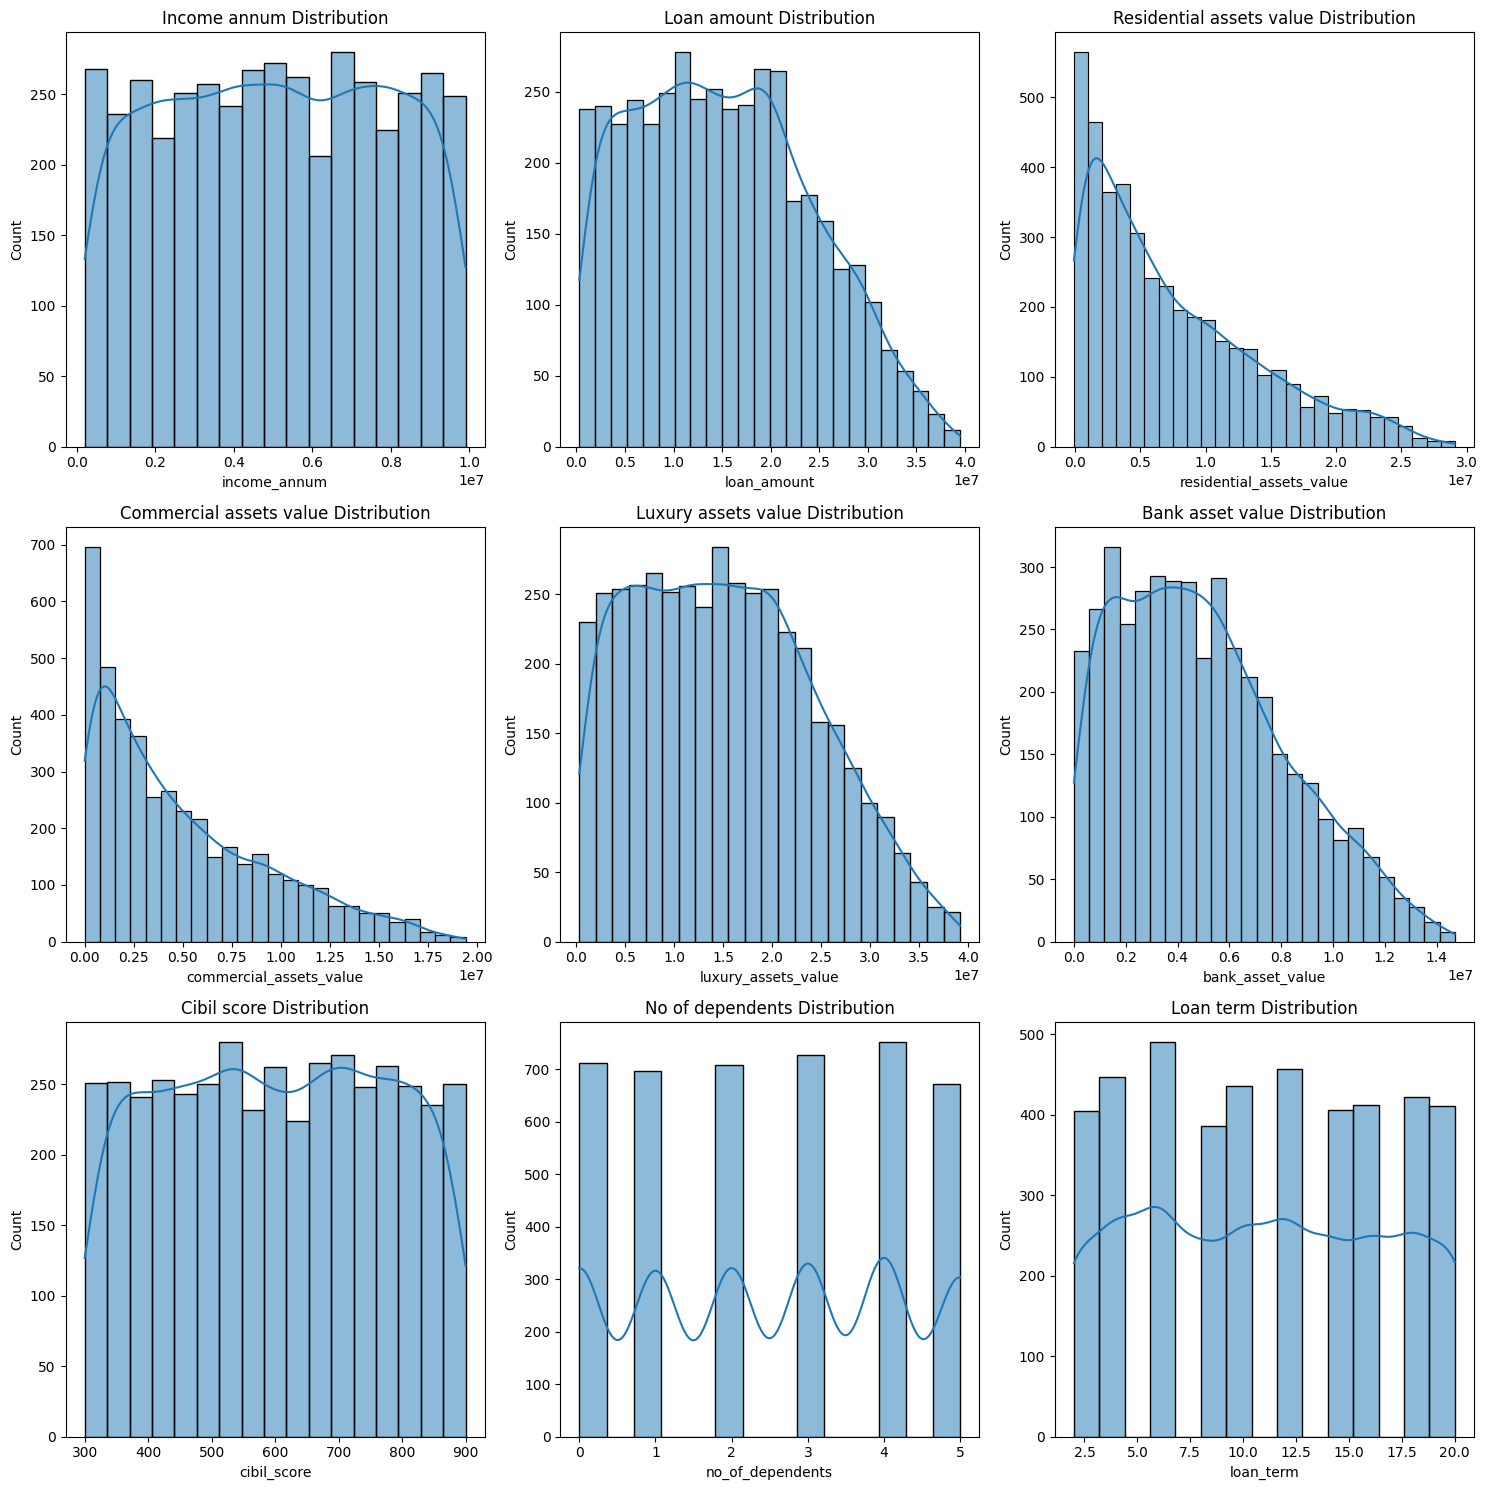

In [215]:

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))  # 3 rows x 3 columns
axes = axes.flatten()  # make it a 1D array for easy indexing

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'{col.replace("_", " ").capitalize()} Distribution')

plt.tight_layout()
plt.show()


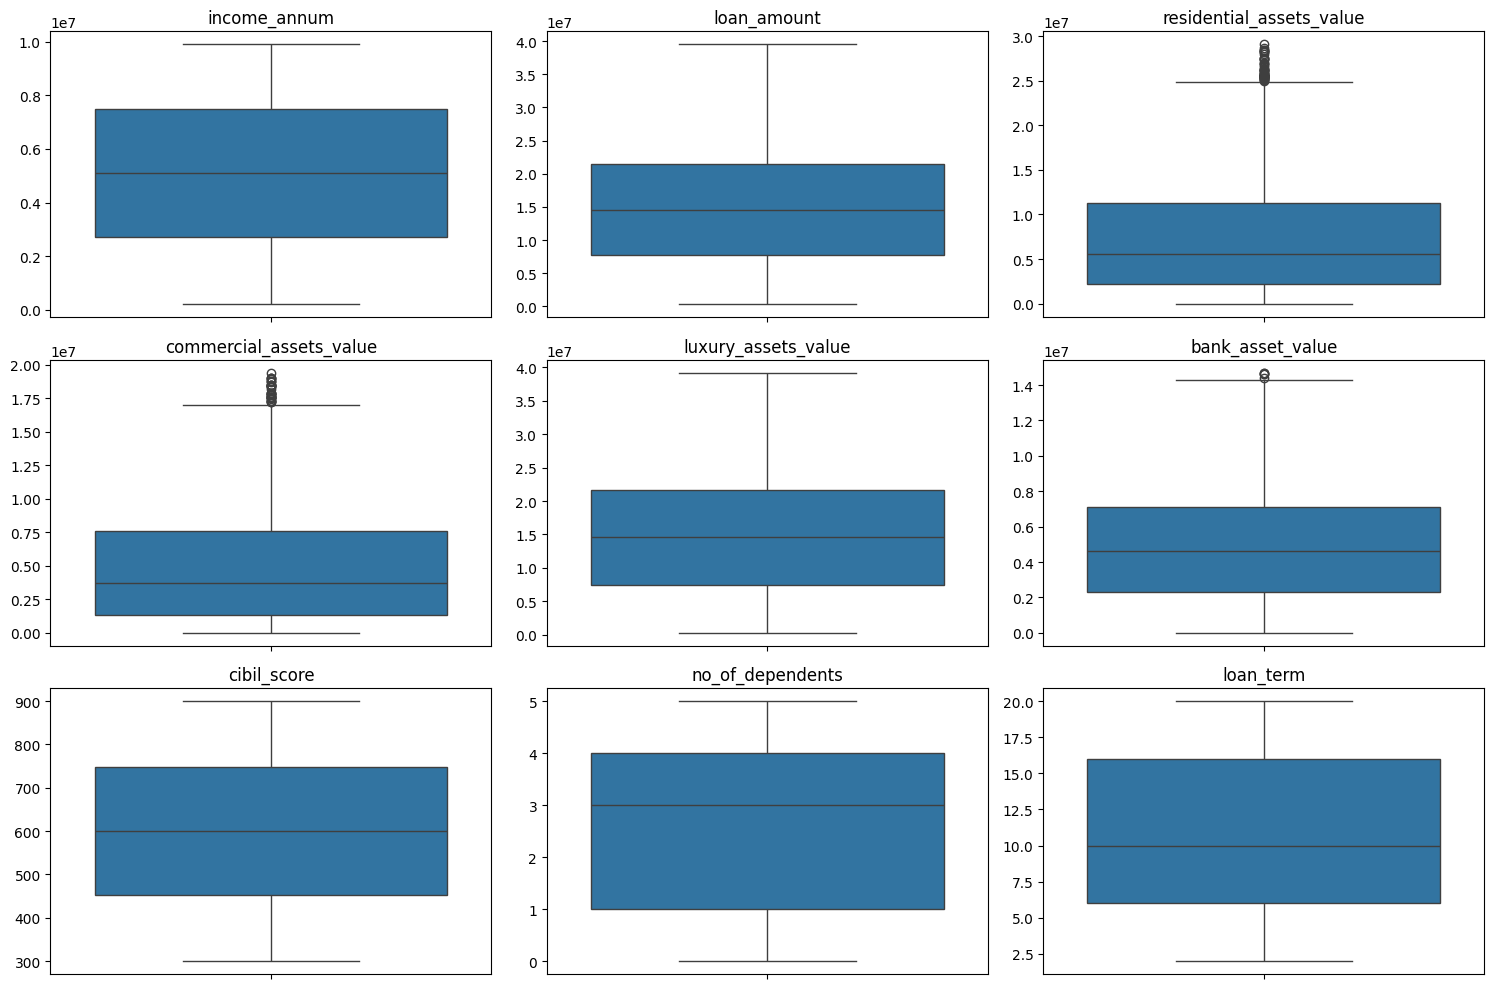

In [216]:


fig, axes = plt.subplots(nrows=3, ncols=3,
                         figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

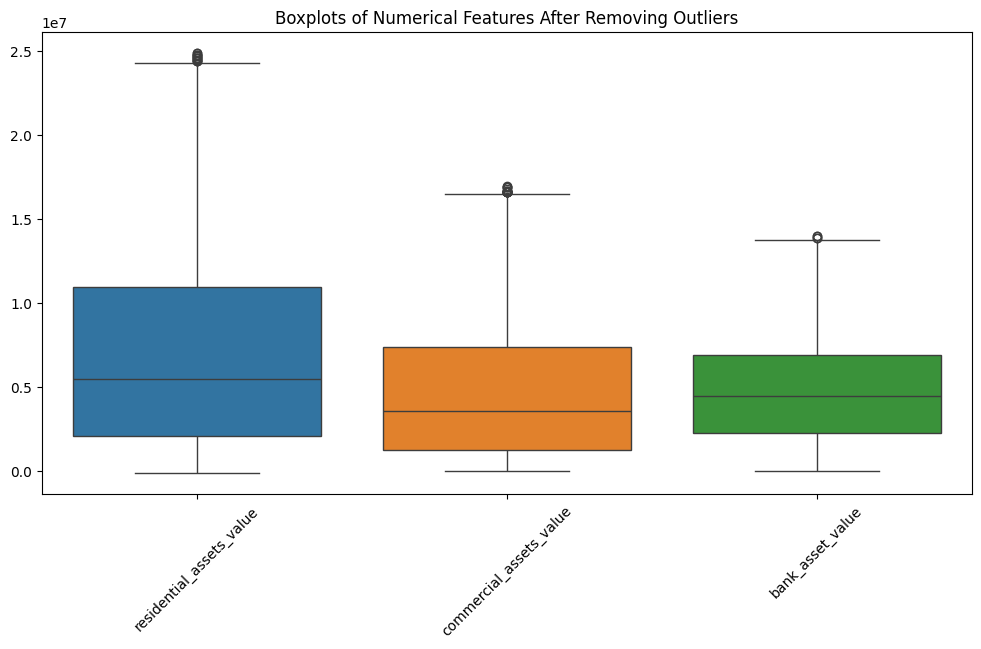

In [217]:
# remove outliers residential_assets_value, commercial_assets_value, luxury_assets_value, bank_asset_value and plot boxplot again
outlier_cols = ['residential_assets_value', 'commercial_assets_value', 'bank_asset_value']
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


#boxplots after removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[outlier_cols])
plt.title("Boxplots of Numerical Features After Removing Outliers")
plt.xticks(rotation=45)  # rotate labels for readability
plt.show()



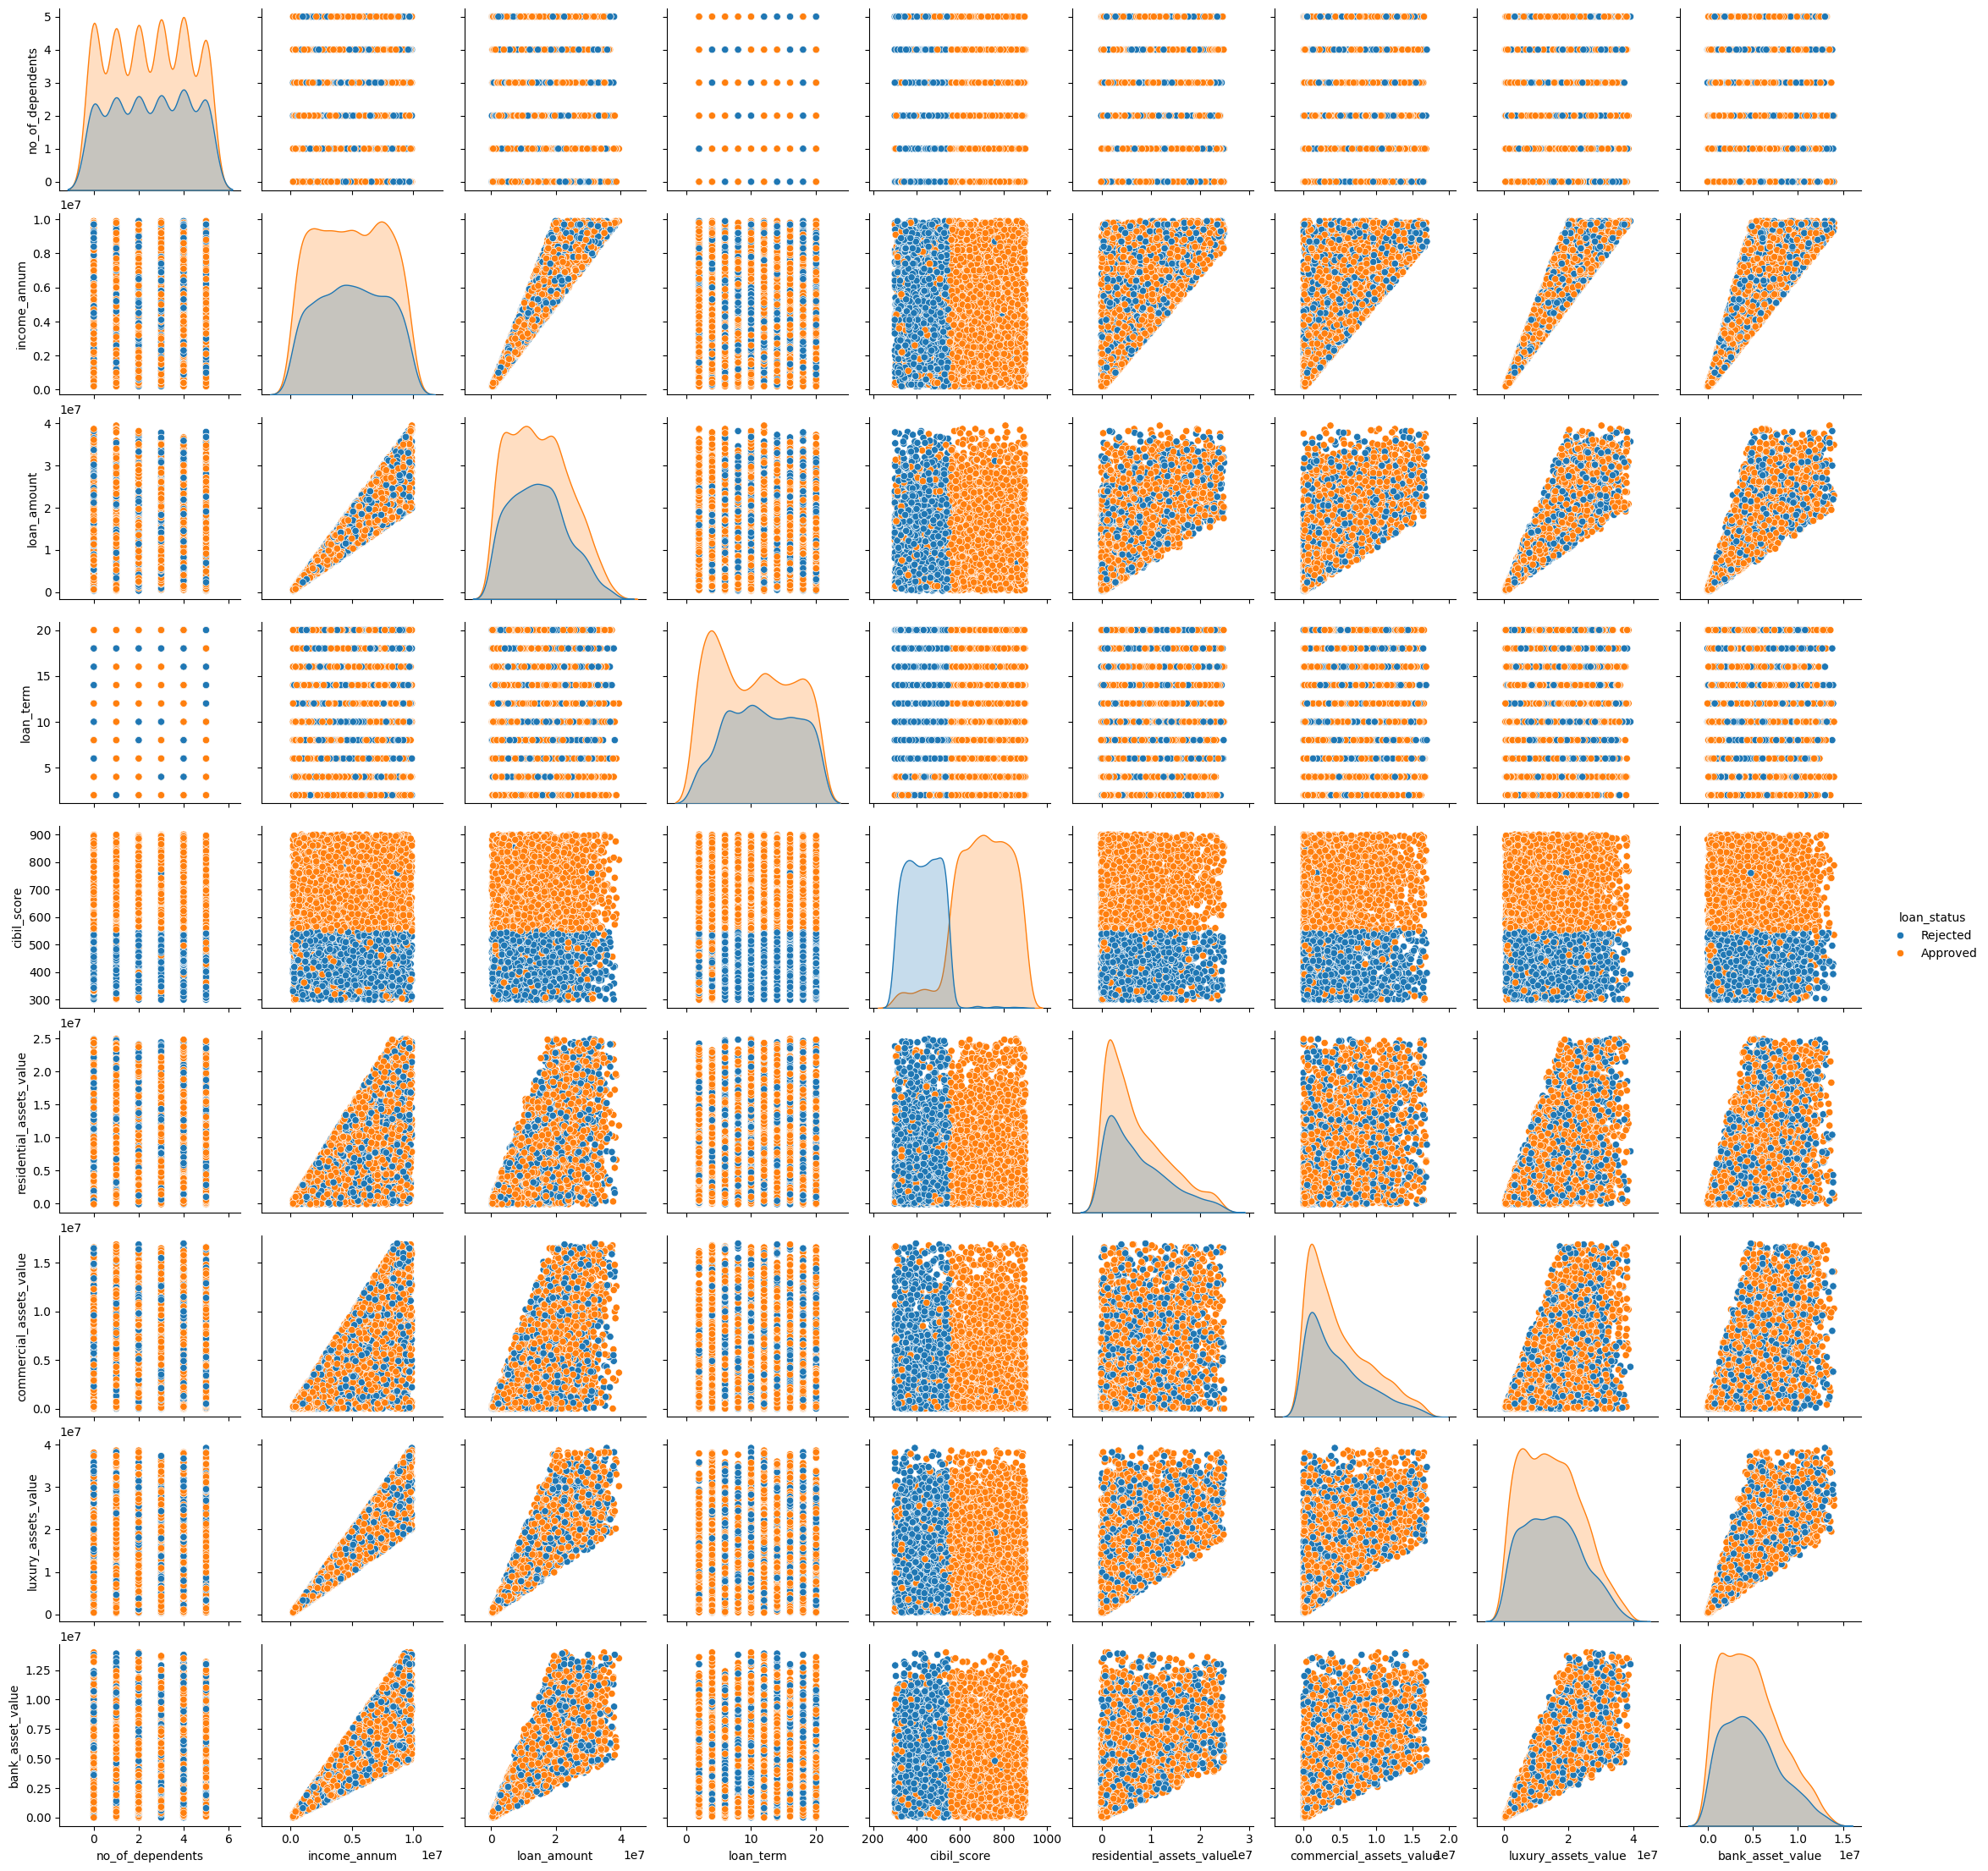

In [218]:
sns.pairplot(df, hue='loan_status')
plt.savefig('pairplot_loan_status.png')
plt.show()



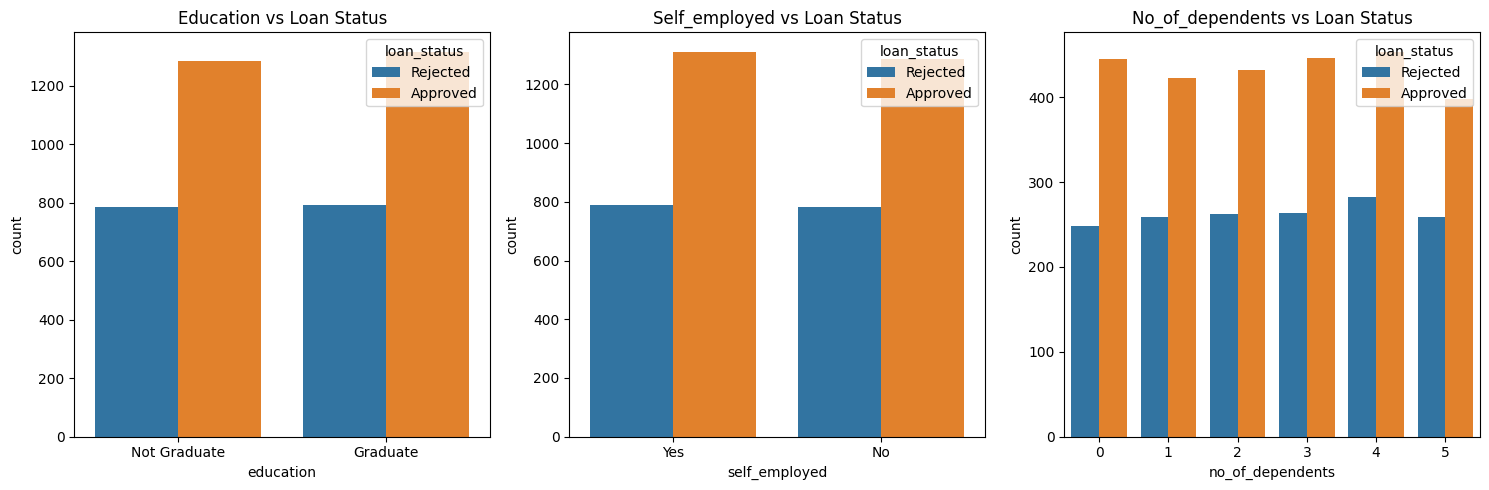

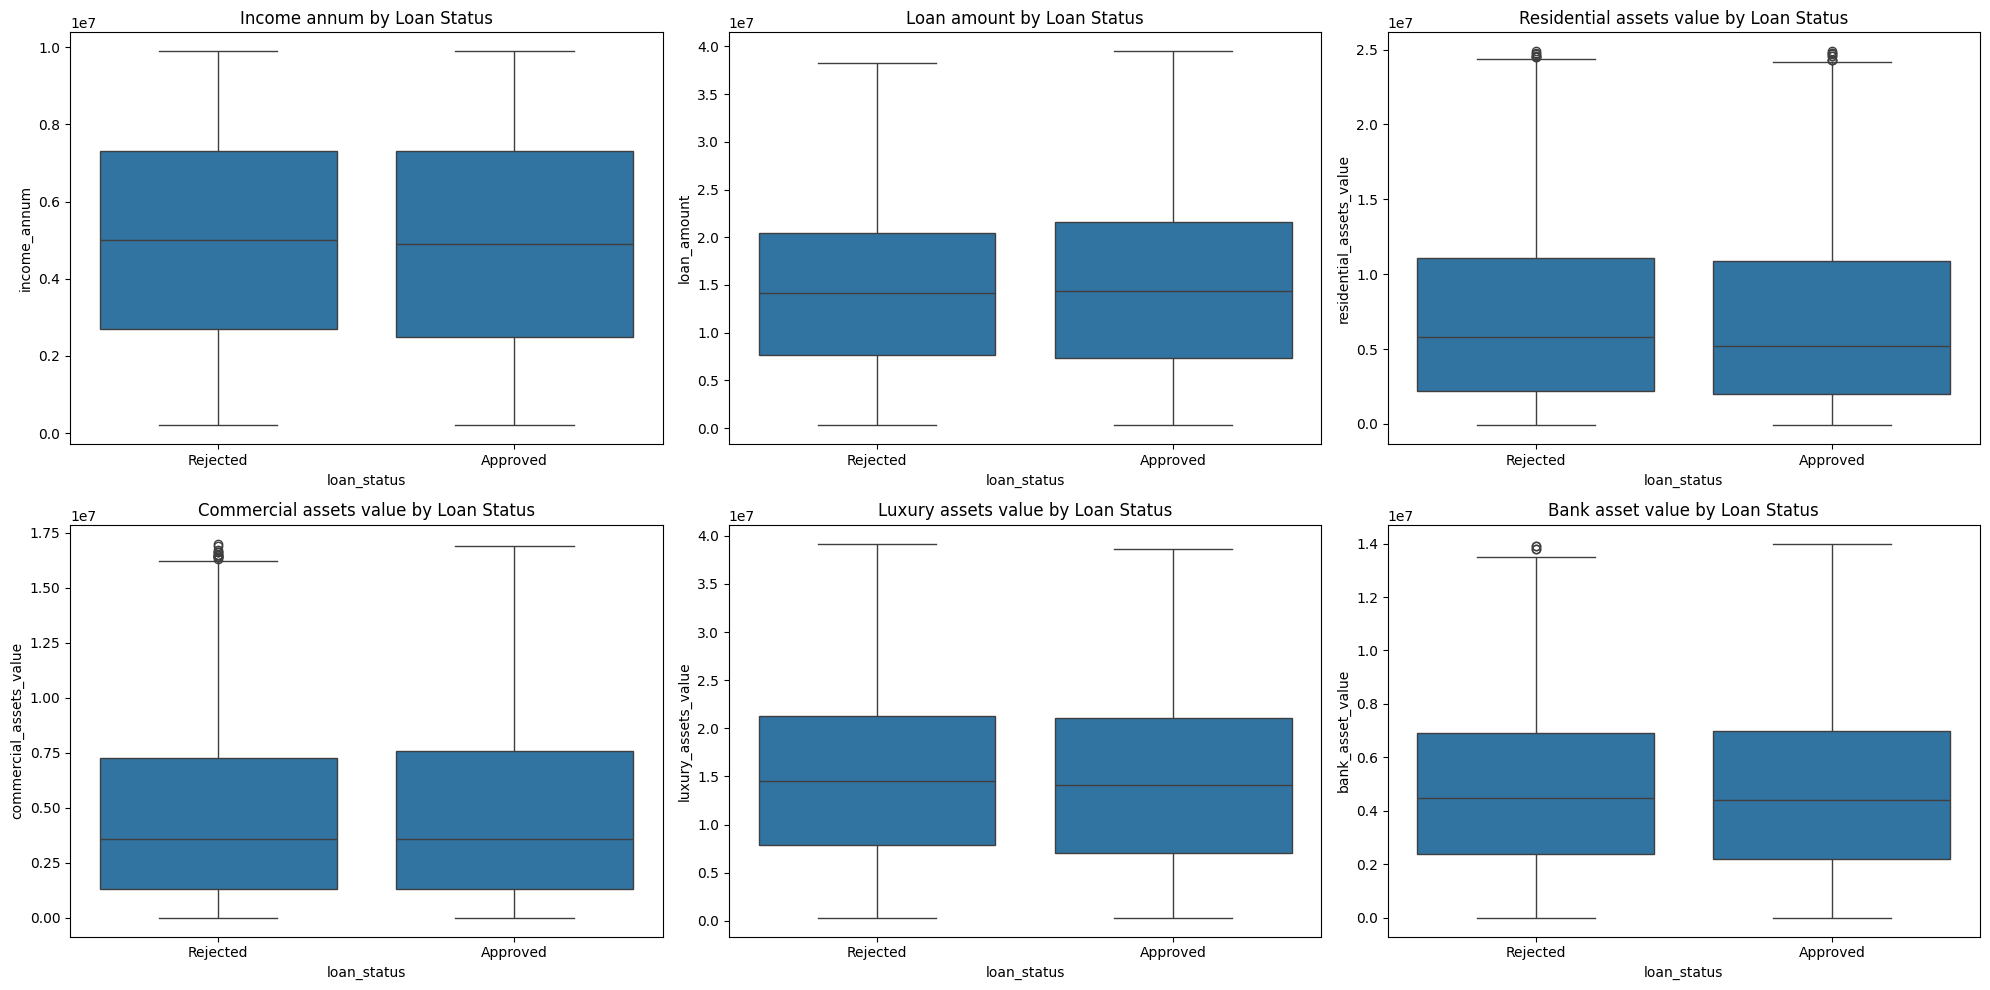

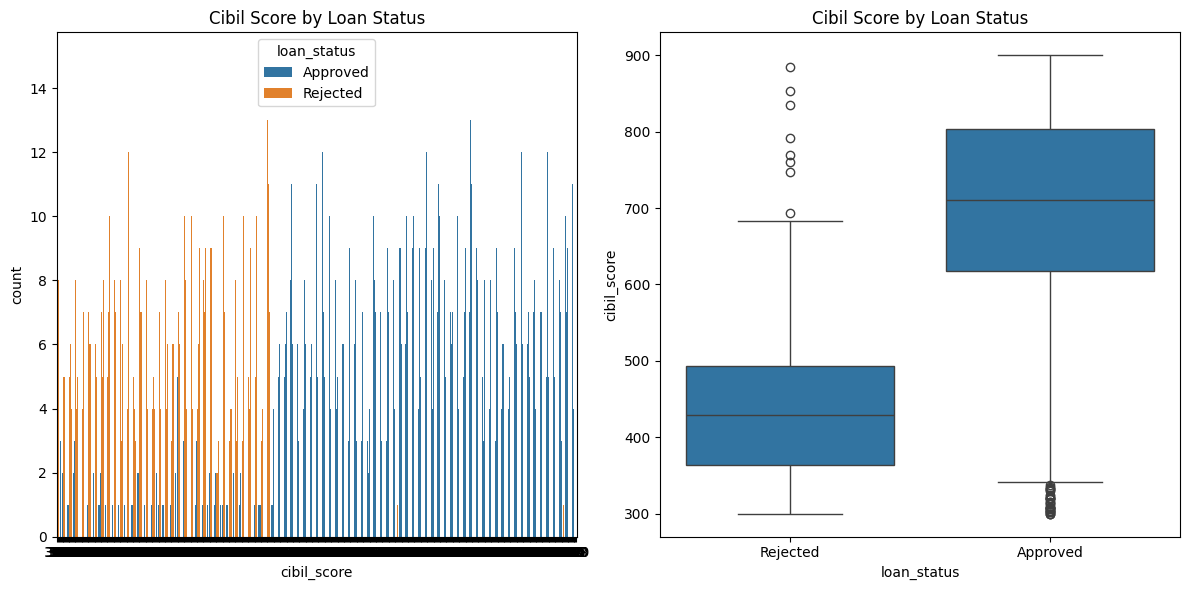

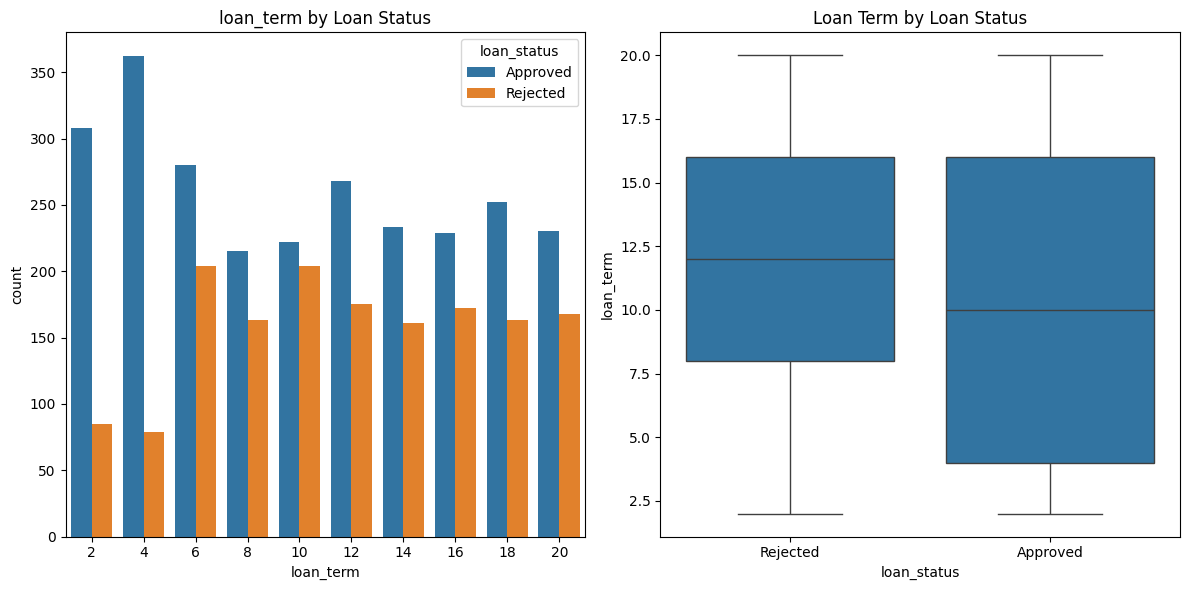

In [219]:
categorical_cols = ['education', 'self_employed','no_of_dependents']

# --- Categorical vs Target ---
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_cols), figsize=(5*len(categorical_cols), 5))

# If there's only 1 categorical col, axes won't be iterable
if len(categorical_cols) == 1:
    axes = [axes]

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='loan_status', data=df, ax=axes[i])
    axes[i].set_title(f'{col.strip().capitalize()} vs Loan Status')

plt.tight_layout()
plt.savefig('categorical_vs_loan_status.png')
plt.show()

numerical_cols = ['income_annum', 'loan_amount', 'residential_assets_value', 'commercial_assets_value',
                    'luxury_assets_value', 'bank_asset_value']

# --- Numerical vs Target (Boxplots) ---
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))  # adjust rows/cols to fit your numerical_cols
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='loan_status', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col.strip().replace("_", " ").capitalize()} by Loan Status')

plt.tight_layout()
plt.savefig('numerical_vs_loan_status_boxplots.png')
plt.show()

# a different box plots for cibil_score and loan_term
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1 row x 2 columns
axes = axes.flatten() 
sns.countplot(x='cibil_score', hue='loan_status', data=df, ax=axes[0])
axes[0].set_title('Cibil Score by Loan Status')
sns.boxplot(x='loan_status', y='cibil_score', data=df, ax=axes[1])
axes[1].set_title('Cibil Score by Loan Status')
plt.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1 row x 2 columns
axes = axes.flatten() 
sns.countplot(x='loan_term', hue='loan_status', data=df, ax=axes[0])
axes[0].set_title('loan_term by Loan Status')
sns.boxplot(x='loan_status', y='loan_term', data=df, ax=axes[1])
axes[1].set_title('Loan Term by Loan Status')
plt.tight_layout()

plt.show()


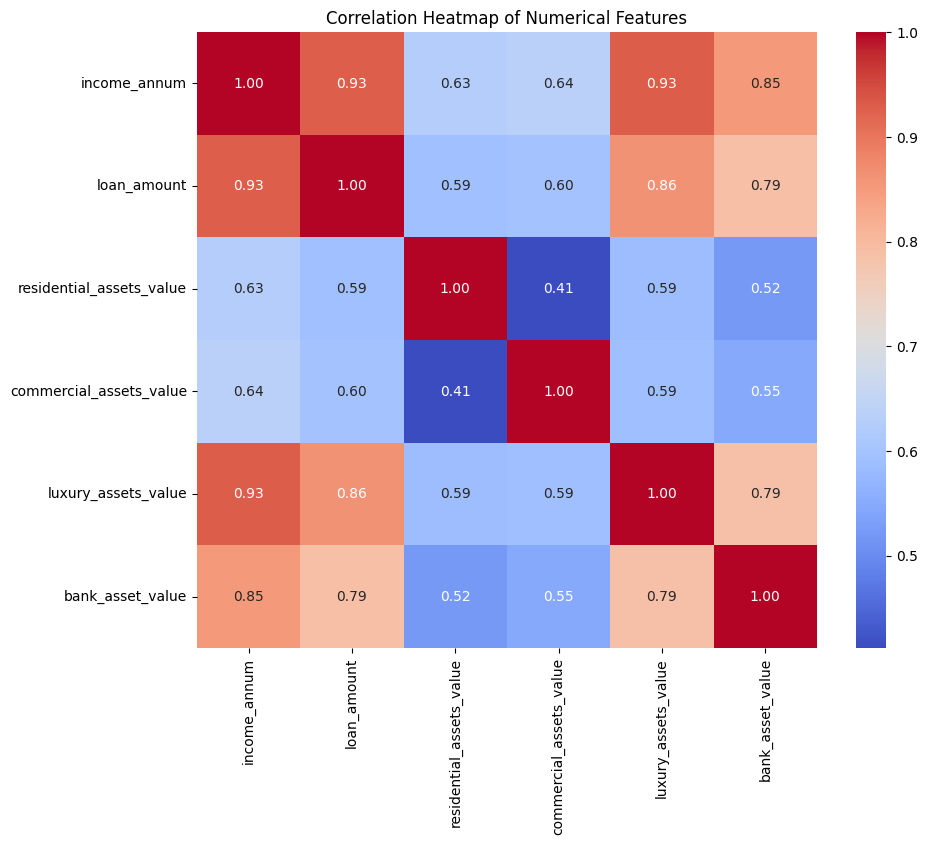

In [221]:

#corr heatmap num_cols
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()  

In [225]:
df.head()

no_of_dependents     education self_employed  income_annum  loan_amount  \
1                 0  Not Graduate           Yes       4100000     12200000   
2                 3      Graduate            No       9100000     29700000   
3                 3      Graduate            No       8200000     30700000   
4                 5  Not Graduate           Yes       9800000     24200000   
5                 0      Graduate           Yes       4800000     13500000   

   loan_term  cibil_score  residential_assets_value  commercial_assets_value  \
1          8          417                   2700000                  2200000   
2         20          506                   7100000                  4500000   
3          8          467                  18200000                  3300000   
4         20          382                  12400000                  8200000   
5         10          319                   6800000                  8300000   

   luxury_assets_value  bank_asset_value loan_status  
1              8800000           3300000    Rejected  
2             33300000          12800000    Rejected  
3             23300000           7900000    Rejected  
4             29400000           5000000    Rejected  
5             13700000           5100000    Rejected

In [226]:



num_cols = ['income_annum', 'loan_amount', 'residential_assets_value', 'commercial_assets_value',
         'luxury_assets_value', 'bank_asset_value', 'cibil_score', 'no_of_dependents', 'loan_term']
cat_cols = ['education', 'self_employed']


pre_smote = ColumnTransformer([
    ("num", RobustScaler(), num_cols),
    ("cat", OrdinalEncoder(), cat_cols)
], remainder="drop")

cat_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))


smote = SMOTENC(categorical_features=cat_indices, random_state=42)



post_smote = ColumnTransformer([
    ("num", "passthrough", list(range(len(num_cols)))),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_indices)
], remainder="drop")


In [230]:

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

X = df.drop(columns='loan_status')
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)





Logistic Regression Results:
              precision    recall  f1-score   support

    Approved       0.95      0.92      0.94       520
    Rejected       0.87      0.92      0.90       315

    accuracy                           0.92       835
   macro avg       0.91      0.92      0.92       835
weighted avg       0.92      0.92      0.92       835



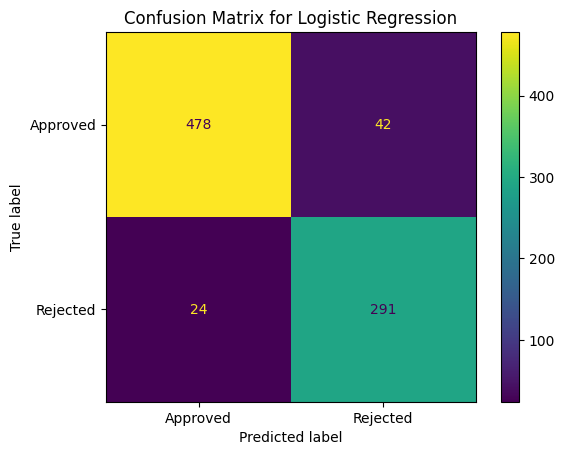


Decision Tree Results:
              precision    recall  f1-score   support

    Approved       0.98      0.99      0.98       520
    Rejected       0.98      0.97      0.97       315

    accuracy                           0.98       835
   macro avg       0.98      0.98      0.98       835
weighted avg       0.98      0.98      0.98       835



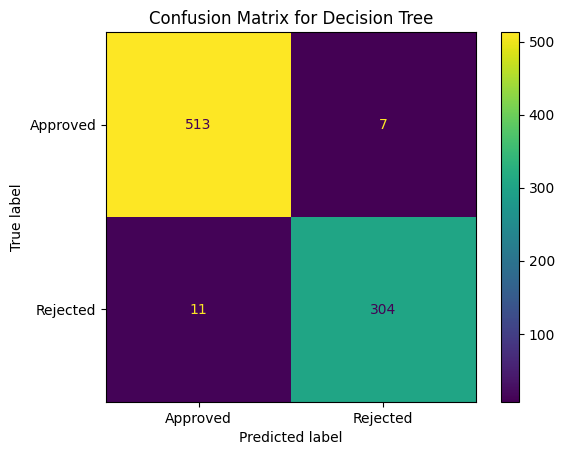


Naive Bayes Results:
              precision    recall  f1-score   support

    Approved       0.98      0.93      0.95       520
    Rejected       0.89      0.97      0.93       315

    accuracy                           0.94       835
   macro avg       0.94      0.95      0.94       835
weighted avg       0.95      0.94      0.94       835



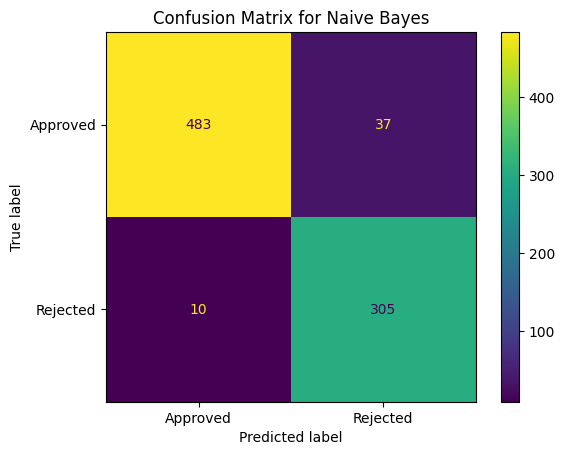


Random Forest Results:
              precision    recall  f1-score   support

    Approved       0.98      0.98      0.98       520
    Rejected       0.97      0.97      0.97       315

    accuracy                           0.98       835
   macro avg       0.97      0.98      0.97       835
weighted avg       0.98      0.98      0.98       835



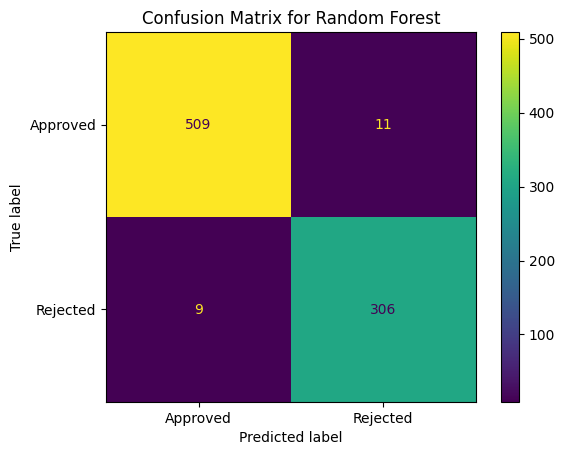

In [232]:

results = {}
for name, clf in classifiers.items():
    pipe = Pipeline([
        ("pre_smote", pre_smote),
        ("smote", smote),
        ("post_smote", post_smote),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    results[name] = classification_report(y_test, y_pred, output_dict=True)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=pipe.classes_)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


In [233]:
rf_model = pipe.named_steps['clf']
rf_model.feature_importances_
feature_names = pipe.named_steps['pre_smote'].get_feature_names_out()
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [234]:
feature_importance_df

Feature  Importance
6                num__cibil_score    0.830532
8                  num__loan_term    0.060528
1                num__loan_amount    0.024107
4        num__luxury_assets_value    0.015115
2   num__residential_assets_value    0.015018
0               num__income_annum    0.014444
3    num__commercial_assets_value    0.012632
5           num__bank_asset_value    0.012402
7           num__no_of_dependents    0.011015
10             cat__self_employed    0.002360
9                  cat__education    0.001846

In [235]:

# Save the full pipeline
joblib.dump(pipe, 'rf_pipeline.joblib')
# Load the full pipeline
loaded_pipe = joblib.load('rf_pipeline.joblib')
# Now you can predict on raw data (with string categoricals)
y_pred = loaded_pipe.predict(X_test)
